## Cel projektu

Celem projektu jest zaprezentowanie procesu analizy danych poprzez zastosowanie elementów analizy statystycznej oraz przy użyciu technik i narzędzi programistycznych. Do analizy wykorzystane zostały dane dotyczące klientów sieci komórkowej ze zbiorów załączonych do książki "Data Analysis using SQL and Excel" Gordon S. Linoff.

Praca jest podzielona na dwie główne części. Piewrsza część dotyczy wczytania i wyczyszczenia danych, natomiast druga część to eksploracja danych, w której analizuję odpływ klientów, czas trwania subskrypcji oraz sprawdzę czy istnieje zależność między miesięczną opłatą za usługę oraz czasem trwania subskrypcji.

## 1. Wczytanie i wyczyszczenie danych

### Import potrzebych bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import scipy.stats
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import seaborn as sns
sns.set(palette = 'pastel')

### Wczytywanie danych z plików csv

Do analizy wykorzystamy subscribers dataset. Są to dane dotyczące klientów sieci komórkowej. Przyjrzyjmy się pierwszym kilku rzędom danych.

In [2]:
subs = pd.read_csv("data\subs.txt", encoding = "cp1251", sep = "\t")
subs.head()

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored
0,48856,Bottom,30,Gotham,Dealer,2001-01-23 00:00:00,2004-08-12 00:00:00,V,1297,0
1,48881,Top,80,Metropolis,Dealer,1997-08-21 00:00:00,2004-01-20 00:00:00,V,2343,0
2,48929,Bottom,30,Gotham,Dealer,1998-05-07 00:00:00,2005-07-17 00:00:00,V,2628,0
3,49074,Top,150,Gotham,Dealer,1999-11-15 00:00:00,NaN,NaN,2600,1
4,49137,Bottom,30,Gotham,Chain,1997-02-13 00:00:00,NaN,NaN,3605,1


### Opis kolumn zawartych w tabeli

- customer_id - indywidualny numer klienta
- rate_plan - plan taryfowy
- monthly_fee - miesięczna opłata
- market - rynek
- channel - kanał dystrybucji
- start_date - data rozpoczęcia subskrypcji
- stop_date - data zakończenia subskrypcji
- tenure - czas trwania sukskrypcji w dniach
- censored - czy klient jest nadal aktywny (w tym przypadku jest to right censoring czyli nie znamy daty zakończenia subskrypcji)

### Sprawdzenie wymiaru DataFrame

In [3]:
subs.shape

(5068035, 10)

### Sprawdzenie formatów danych i czyszczenie

Przyjrzyjmy się danym trochę bliżej.

In [4]:
subs.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5068035 entries, 0 to 5068034
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   customer_id  5068035 non-null  int64 
 1   rate_plan    5068035 non-null  object
 2   monthly_fee  5068035 non-null  int64 
 3   market       5068035 non-null  object
 4   channel      5068035 non-null  object
 5   start_date   5067854 non-null  object
 6   stop_date    2677076 non-null  object
 7   stop_type    2677076 non-null  object
 8   tenure       5068035 non-null  int64 
 9   censored     5068035 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 386.7+ MB


Sprawdzamy ile % danych brakuje w każdej kolumnie

In [5]:
subs.isnull().sum()/subs.shape[0]

customer_id    0.000000
rate_plan      0.000000
monthly_fee    0.000000
market         0.000000
channel        0.000000
start_date     0.000036
stop_date      0.471772
stop_type      0.471772
tenure         0.000000
censored       0.000000
dtype: float64

Kolumny stop_date oraz stop_type mogą zawierać NaN. Jest to informacja, że klient nadal pozostaje aktywny.

Usuwamy wiersze w których kolumna start_date jest pusta.

In [6]:
subs = subs.dropna(subset = ['start_date'])

Ponownie sprawdzamy ile % danych brakuje w każdnej kolumnie.

In [7]:
subs.isnull().sum()/subs.shape[0]

customer_id    0.000000
rate_plan      0.000000
monthly_fee    0.000000
market         0.000000
channel        0.000000
start_date     0.000000
stop_date      0.471756
stop_type      0.471756
tenure         0.000000
censored       0.000000
dtype: float64

Zmieniamy typ kolumn start_date, stop_date na typ datetime

In [8]:
subs['start_date'] = pd.to_datetime(subs['start_date'])

In [9]:
subs['stop_date'] = pd.to_datetime(subs['stop_date'])

In [10]:
subs.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5067854 entries, 0 to 5068034
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   customer_id  5067854 non-null  int64         
 1   rate_plan    5067854 non-null  object        
 2   monthly_fee  5067854 non-null  int64         
 3   market       5067854 non-null  object        
 4   channel      5067854 non-null  object        
 5   start_date   5067854 non-null  datetime64[ns]
 6   stop_date    2677061 non-null  datetime64[ns]
 7   stop_type    2677061 non-null  object        
 8   tenure       5067854 non-null  int64         
 9   censored     5067854 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(4)
memory usage: 425.3+ MB


Sprawdźmy jak wyglądają wartości w kolumnach stop_type, rate_plan oraz tenure

In [11]:
# kolumna stop_type
subs.stop_type.unique()

array(['V', nan, 'I', 'M'], dtype=object)

Gdzie:
- NaN - klient jest nadal aktywny
- V - "Voluntary" - subskrypcja przerwana przez klienta
- M - "Migration" - klient przerzucił się na inny produkt
- I - "Involuntary" - subskrypcja przerwana przez firmę, najczęściej z powodu braku płatności

In [12]:
# kolumna rate_plan
subs.rate_plan.unique()

array(['Bottom', 'Top', 'Middle'], dtype=object)

Mamy trzy plany taryfowe:
- bottom
- middle
- top

Sprawdżmy jakie wartości minimalne oraz maksymalne przyjmują odpowiednie plany

Minimalne wartości:

In [13]:
subs.groupby('rate_plan')['monthly_fee'].min()

rate_plan
Bottom     0
Middle    40
Top       70
Name: monthly_fee, dtype: int64

Miesięczna opłata za usługę nie może być równa 0, zatem sprawdzamy dla jakich rekordów ona występuje i je usuwamy.

In [14]:
subs[subs['monthly_fee'] == 0]

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored
187763,10087336,Bottom,0,Gotham,Dealer,2000-05-19,2004-05-18,V,1460,0
190497,10232971,Bottom,0,Gotham,Dealer,2000-08-04,2004-04-22,I,1357,0
213861,11478217,Bottom,0,Gotham,Dealer,2000-02-12,2004-01-06,V,1424,0
224016,12023474,Bottom,0,Gotham,Dealer,2000-07-06,2004-10-18,V,1565,0
273091,14641312,Bottom,0,Gotham,Dealer,2000-12-12,2004-03-20,V,1194,0
284675,15253125,Bottom,0,Gotham,Dealer,1998-06-15,2004-12-07,I,2367,0
301087,18173245,Bottom,0,Gotham,Dealer,2001-10-21,NaT,NaN,1894,1
408806,29031786,Bottom,0,Gotham,Dealer,2002-04-29,NaT,NaN,1704,1
541429,48317197,Bottom,0,Gotham,Dealer,2002-09-10,2004-05-29,V,627,0
587136,53886416,Bottom,0,Metropolis,Dealer,2001-11-30,2004-08-02,V,976,0


In [15]:
subs = subs[subs['monthly_fee'] > 0]
subs

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored
0,48856,Bottom,30,Gotham,Dealer,2001-01-23,2004-08-12,V,1297,0
1,48881,Top,80,Metropolis,Dealer,1997-08-21,2004-01-20,V,2343,0
2,48929,Bottom,30,Gotham,Dealer,1998-05-07,2005-07-17,V,2628,0
3,49074,Top,150,Gotham,Dealer,1999-11-15,NaT,NaN,2600,1
4,49137,Bottom,30,Gotham,Chain,1997-02-13,NaT,NaN,3605,1
...,...,...,...,...,...,...,...,...,...,...
5068030,115985518,Middle,60,Smallville,Dealer,2006-12-28,NaT,NaN,0,1
5068031,115985519,Bottom,40,Smallville,Chain,2006-12-28,NaT,NaN,0,1
5068032,115985520,Bottom,40,Smallville,Chain,2006-12-28,NaT,NaN,0,1
5068033,115985521,Bottom,40,Smallville,Chain,2006-12-28,NaT,NaN,0,1


Sprawdzamy jeszcze raz minimalne wartości:

In [16]:
subs.groupby('rate_plan')['monthly_fee'].min()

rate_plan
Bottom     7
Middle    40
Top       70
Name: monthly_fee, dtype: int64

Maksymalne wartości:

In [17]:
subs.groupby('rate_plan')['monthly_fee'].max()

rate_plan
Bottom     40
Middle     60
Top       360
Name: monthly_fee, dtype: int64

In [18]:
# kolumna tenure
subs.tenure.unique()

array([1297, 2343, 2628, ..., 5080, 4985,  -11], dtype=int64)

W kolumnie tenure wystepuja ujemne wartości w niektórych wierszach, zatem je usuwamy, gdyż czas trwania subskrypcji nie może być ujemny.

In [19]:
subs = subs[subs['tenure'] >= 0]

Wszystkie kolumny typu object zmieniamy na typ string i małe litery

In [20]:
subs['rate_plan'] = subs.rate_plan.apply(lambda x: str(x).lower())

In [21]:
subs['market'] = subs.market.apply(lambda x: str(x).lower())

In [22]:
subs['channel'] = subs.channel.apply(lambda x: str(x).lower())

In [23]:
subs['stop_type'] = subs.stop_type.apply(lambda x: str(x).lower())

Sprawdzamy czy w naszej DataFrame sa duplikaty

In [24]:
subs[subs.duplicated()]

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored


Dodajemy kolumnę churn

In [25]:
subs['churn'] = subs['censored'].apply(lambda x: 0 if x == 1 else 1)

Kolumna censored jest nam nie potrzebna zatem ją usuwamy

In [26]:
subs.drop(columns = 'censored')

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,churn
0,48856,bottom,30,gotham,dealer,2001-01-23,2004-08-12,v,1297,1
1,48881,top,80,metropolis,dealer,1997-08-21,2004-01-20,v,2343,1
2,48929,bottom,30,gotham,dealer,1998-05-07,2005-07-17,v,2628,1
3,49074,top,150,gotham,dealer,1999-11-15,NaT,nan,2600,0
4,49137,bottom,30,gotham,chain,1997-02-13,NaT,nan,3605,0
...,...,...,...,...,...,...,...,...,...,...
5068030,115985518,middle,60,smallville,dealer,2006-12-28,NaT,nan,0,0
5068031,115985519,bottom,40,smallville,chain,2006-12-28,NaT,nan,0,0
5068032,115985520,bottom,40,smallville,chain,2006-12-28,NaT,nan,0,0
5068033,115985521,bottom,40,smallville,chain,2006-12-28,NaT,nan,0,0


### Wylistujmy kolumny DataFrame

In [27]:
subs.columns

Index(['customer_id', 'rate_plan', 'monthly_fee', 'market', 'channel',
       'start_date', 'stop_date', 'stop_type', 'tenure', 'censored', 'churn'],
      dtype='object')

### Sprawdźmy jak wygląda aktualnie DataFrame

In [28]:
subs.head()

,customer_id,rate_plan,monthly_fee,market,channel,start_date,stop_date,stop_type,tenure,censored,churn
0,48856,bottom,30,gotham,dealer,2001-01-23,2004-08-12,v,1297,0,1
1,48881,top,80,metropolis,dealer,1997-08-21,2004-01-20,v,2343,0,1
2,48929,bottom,30,gotham,dealer,1998-05-07,2005-07-17,v,2628,0,1
3,49074,top,150,gotham,dealer,1999-11-15,NaT,nan,2600,1,0
4,49137,bottom,30,gotham,chain,1997-02-13,NaT,nan,3605,1,0


In [29]:
subs.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5067840 entries, 0 to 5068034
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   customer_id  5067840 non-null  int64         
 1   rate_plan    5067840 non-null  object        
 2   monthly_fee  5067840 non-null  int64         
 3   market       5067840 non-null  object        
 4   channel      5067840 non-null  object        
 5   start_date   5067840 non-null  datetime64[ns]
 6   stop_date    2677049 non-null  datetime64[ns]
 7   stop_type    5067840 non-null  object        
 8   tenure       5067840 non-null  int64         
 9   censored     5067840 non-null  int64         
 10  churn        5067840 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 464.0+ MB


## 2. Analiza eksploracyjna

W tabeli subs znajdują się dane numeryczne kolumny: monthly_fee oraz tenure oraz dane kategorialne kolumny: rate_plan, market, channel, stop_type, start_date, stop_date, censored, churn.

Zacznijmy od analizy dat rozpoczęcia subskrypcji. Sprawdźmy jakie mamy wartości.

In [30]:
subs.start_date.dt.year.unique()

array([2001, 1997, 1998, 1999, 2000, 2004, 1995, 1996, 1994, 1993, 1992,
       1991, 1990, 1989, 2002, 1988, 2003, 1958, 2005, 2006], dtype=int64)

Zauważmy, że w danych pojawia się rok 1958 co jest ewidentnym błędem w danych, gdyż pierwsza sieć komórkowa powstała w 1979. Zatem usuwamy wiersze z tą wartością.

In [31]:
subs = subs[subs['start_date'].dt.year >= 1979]

Dokonujemy analizy dat rozpoczęcia i zakończenia subskrypcji w zależności od roku

Rozpoczęcie subskrypcji:

In [32]:
subs.groupby(subs['start_date'].dt.year).size() #liczba klientów rozpoczynających subskrypcje w danym roku

start_date
1988         70
1989        213
1990        596
1991       1011
1992       2288
1993       3890
1994       7371
1995      11638
1996      22320
1997      42462
1998      66700
1999     102617
2000     146970
2001     250469
2002     482288
2003     865218
2004    1112706
2005    1292819
2006     656193
dtype: int64

In [33]:
start_year_subs = pd.pivot_table(subs, index = subs['start_date'].dt.year, values = ['customer_id'], aggfunc = lambda x: 100 * len(x.unique()) / subs.shape[0], margins = True, margins_name = 'ALL')

In [34]:
round(start_year_subs, 2) #procent wszystkich klientów

,customer_id
start_date,
1988,0.00
1989,0.00
1990,0.01
1991,0.02
1992,0.05
1993,0.08
1994,0.15
1995,0.23
1996,0.44


Jaki procentowy spadek w liczbie nowych klientów nastąpił na przełomie 2005 i 2006 roku

In [35]:
round(100-((len(subs[subs['start_date'].dt.year == 2006])/len(subs[subs['start_date'].dt.year == 2005]))*100),2)

49.24

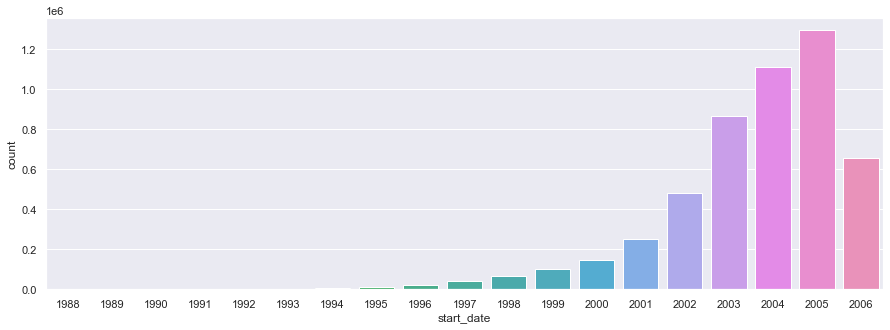

In [36]:
plt.figure(figsize = (15,5))
sns.countplot(subs['start_date'].dt.year.astype('Int64').sort_values())
plt.show()

Zakończenie subskrypcji:

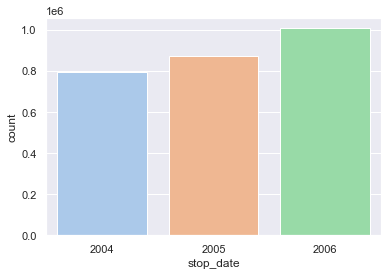

In [37]:
sns.countplot(subs['stop_date'].dt.year.astype('Int64').sort_values())
plt.show()

Widzimy, że nie ma informacji o rezygnacjach przed 2004 rokiem, zatem możemy podejrzewać, że dane zostały wprowadzone w 2004 roku i wzięto tylko pod uwagę aktywnych użytkowników. Zatem w celu dalszej analizy zajmiemy się tylko danymi od 2004. 

In [38]:
subs = subs[subs['start_date'].dt.year >= 2004]

Sprawdźmy jaki jest procentowy stosunek klientów, którzy zrezygnowali do nowych klientów w danym roku.

Rok 2006:

In [39]:
round(len(subs[subs['stop_date'].dt.year == 2006])/len(subs[subs['start_date'].dt.year == 2006])*100,2)

113.6

Rok 2005:

In [40]:
round(len(subs[subs['stop_date'].dt.year == 2005])/len(subs[subs['start_date'].dt.year == 2005])*100,2)

40.78

Rok 2004:

In [41]:
round(len(subs[subs['stop_date'].dt.year == 2004])/len(subs[subs['start_date'].dt.year == 2004])*100,2)

17.42

Wnioski:
- ilość nowych subskrypcji wzrastała, aż do 2005 roku, natomiast w 2006 nastapił spadek nowych subskrypcji o 49.24% w porównaniu do 2005 roku
- w 2006 roku więcej klientów zrezygnowało z sybskrypcji niż do niej przystąpiło

#### Ile jest aktywnych oraz nieaktywnych klientów

Kolumna "churn" opisuje czy dany klient zrezygnował z sybskrypcji od czy nadal subskrybuje:
- 0 - klient nadal subskrybuje
- 1 - klient zrezygnował z subskrypcji

In [42]:
subs['churn'].value_counts()

0    1595299
1    1466419
Name: churn, dtype: int64

Jaki jest procent klientów, którzy odeszli, a jaki tych którzy pozostali od 2004 do 2006 roku włącznie

In [43]:
num_retained = subs[subs['churn'] == 0].shape[0]
num_churned = subs[subs['churn'] == 1].shape[0]

print(round((num_retained/(num_retained + num_churned) * 100),2), '% klientów zostało')
print(round((num_churned/(num_retained + num_churned) * 100),2), '% klientów odeszło')

52.1 % klientów zostało
47.9 % klientów odeszło


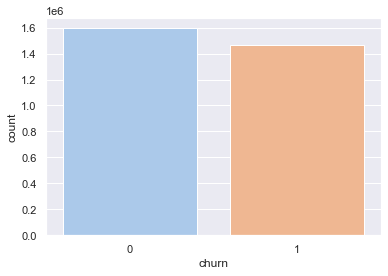

In [44]:
sns.countplot(subs['churn'])
plt.show()

Wnioski:
- więkoszość klientów została, jednak jest to niewielka 4,2 procentowa różnica 

#### Ile klientów zrezygnowało na danym rynku

In [45]:
market_churn = pd.pivot_table(subs, index = ['market'], values = ['customer_id'], columns = ['churn'], aggfunc = lambda x: 100 * len(x.unique()) / subs.shape[0], margins = True, margins_name = 'ALL')

In [46]:
round(market_churn, 2) #procent wszystkich klientów

customer_id               
churn                0      1     ALL
market                               
gotham           22.38  26.59   48.97
metropolis       16.97  15.54   32.52
smallville       12.75   5.76   18.51
ALL              52.10  47.90  100.00

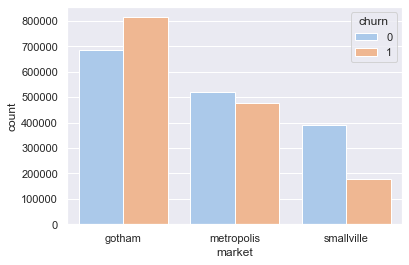

In [47]:
sns.countplot(x = 'market', hue = 'churn', data = subs)
plt.show()

Wnioski:
- na rynku gotham liczba klientów, którzy odeszli przewyższa liczbę klientów, którzy zostali
- na rynku metropolis liczba klientów, którzy odeszli jest zbliżona do liczby klientów, którzy pozostali jednakże na korzyść tych drugich
- na rynku smallville liczba klientów, którzy pozostali ponad dwukrotnie przewyższa liczbę klientów, którzy odeszli
- rynek gotham ma największą liczbę klientów, natomiast smallville najmniejszą

#### Ile klientów zrezygnowało z podziałem na rate_plan

In [48]:
plan_churn = pd.pivot_table(subs, index = ['rate_plan'], values = ['customer_id'], columns = ['churn'], aggfunc = lambda x: 100 * len(x.unique()) / subs.shape[0], margins = True, margins_name = 'ALL')

In [49]:
round(plan_churn, 2) #procent wszystkich klientów

customer_id               
churn               0      1     ALL
rate_plan                           
bottom          44.32  39.46   83.78
middle           5.85   5.66   11.50
top              1.94   2.78    4.72
ALL             52.10  47.90  100.00

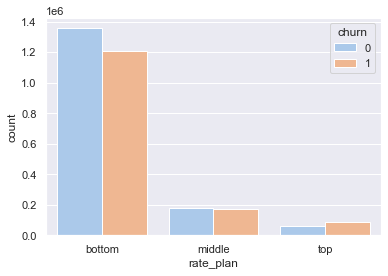

In [50]:
sns.countplot(x = 'rate_plan', hue = 'churn', data = subs)
plt.show()

Wnioski:
- najwięcej klientów decyduje się na bottom plan, natmiast najmniej na top plan
- ilość klientów, którzy pozostali przewyższa liczbę klientów, którzy odeszli dla planów bottom oraz middle
- ilość klientów, którzy odeszli przewyższa liczbę klientów, którzy pozostali dla planu top

#### Ile klientów zrezygnowało z podziałem na kanał dystrybucji

In [51]:
channel_churn = pd.pivot_table(subs, index = ['channel'], values = ['customer_id'], columns = ['churn'], aggfunc = lambda x: 100 * len(x.unique()) / subs.shape[0], margins = True, margins_name = 'ALL')

In [52]:
round(channel_churn, 2) #procent wszystkich klientów

customer_id               
churn             0      1     ALL
channel                           
chain          5.60   6.24   11.84
dealer        25.28  28.02   53.30
mail           9.29   8.41   17.70
store         11.94   5.23   17.17
ALL           52.10  47.90  100.00

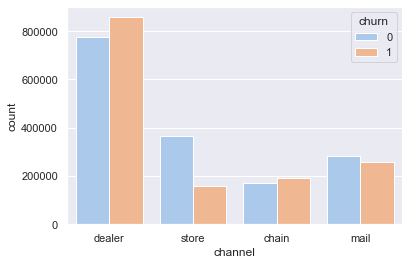

In [53]:
sns.countplot(x = 'channel', hue = 'churn', data = subs)
plt.show()

Wnioski:
- w przypadku kanału dealer oraz chain liczba klientów, którzy odeszli jest większa niż tych, którzy pozostali
- w przypadku kanału store liczba klientów, którzy pozostali ponad dwukrotnie przewyższa liczbę klientów, którzy odeszli
- w przypadku maila liczba klientów, którzy pozostali nieznacznie przewyższa liczbę klientów, którzy odeszli
- największa liczba klientów pochodzi z kanału dealer, a najmniejsza z chain
- w przyszłej analizie należy sprawdzić dlaczego najwięcej klientów zostaje z kanału store (sklep) i dlaczego inne kanały gorzej działają

#### Jaka była najczęstsza przyczyna zakończenia subskrypcji

Ku przypomnieniu, przyczyny zakończenia subskrypcji:
- V - "Voluntary" - subskrypcja przerwana przez klienta
- M - "Migration" - klient przerzucił się na inny produkt
- I - "Involuntary" - subskrypcja przerwana przez firmę, najczęściej z powodu braku płatności

In [54]:
subs_stop = subs[subs['churn'] == 1]

In [55]:
stop_churn = pd.pivot_table(subs_stop, index = ['stop_type'], values = ['customer_id'], columns = ['churn'], aggfunc = lambda x: 100 * len(x.unique()) / subs_stop.shape[0], margins = False)

In [56]:
round(stop_churn, 2) #procent wszystkich klientów, którzy zrezygnowali z subskrypcji

,customer_id
churn,1
stop_type,
i,35.96
m,0.63
v,63.41


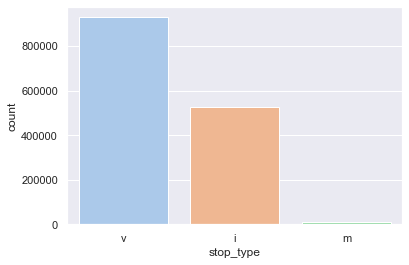

In [57]:
sns.countplot(x = 'stop_type', data = subs.dropna())
plt.show()

Wnioski:
Najczęstszą przyczyną zakończenia subskrypcji była rezygnacja klienta (v - voluntary)

#### W którym roku najwięcej ludzi zrezygnowało i z jakiego powodu

In [58]:
subs_year = subs.copy()
subs_year = subs_year[subs_year['churn'] == 1]
subs_year['stop_year'] = subs_year['stop_date'].dt.year.astype('Int64')

In [59]:
year_stop_type = pd.pivot_table(subs_year, index = ['stop_type'], values = ['customer_id'], columns = ['stop_year'], aggfunc = lambda x: 100 * len(x.unique()) / subs_year.shape[0], margins = True, margins_name = 'ALL')
round(year_stop_type, 2) #w procentach 

customer_id                      
stop_year        2004   2005   2006     ALL
stop_type                                  
i                6.16  13.69  16.10   35.96
m                0.12   0.25   0.26    0.63
v                6.94  22.00  34.47   63.41
ALL             13.22  35.95  50.83  100.00

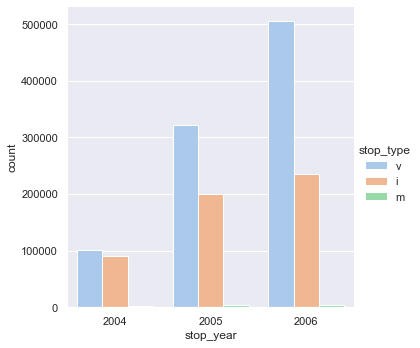

In [60]:
yst = sns.catplot("stop_year", data=subs_year.dropna(), kind="count", hue = "stop_type")

Sprawdżmy jaki był procentowy stosunek liczby osób, które zrezygnowały do liczby wszystkich subskrybentów w danym roku:

Rok 2006:

In [61]:
round(len(subs[subs['stop_date'].dt.year == 2006])/(len(subs[subs['start_date'].dt.year <= 2006]) - len(subs[subs['stop_date'].dt.year < 2006]))*100,2)

31.85

Rok 2005:

In [62]:
round(len(subs[subs['stop_date'].dt.year == 2005])/(len(subs[subs['start_date'].dt.year <= 2005]) - len(subs[subs['stop_date'].dt.year < 2005]))*100,2)

23.83

Rok 2004:

In [63]:
round(len(subs[subs['stop_date'].dt.year == 2004])/len(subs[subs['start_date'].dt.year <= 2004])*100,2)

17.42

Wnioski: 
- Najwięcej ludzi zrezygnowało w 2006 roku
- Stosunek ludzi rezygnujących z subskrypcji do liczby wszystkich subskrybentów z roku na rok rósł
- Najwięcej ludzi każdego roku rezygnowało na swój własny wniosek (voluntary), a najmniej ludzi migrowało do innej sieci (migration)

#### W którym roku najwięcej ludzi zrezygnowało i na jakim rynku

In [64]:
year_market = pd.pivot_table(subs_year, index = ['market'], values = ['customer_id'], columns = ['stop_year'], aggfunc = lambda x: 100 * len(x.unique()) / subs_year.shape[0], margins = True, margins_name = 'ALL')
round(year_market, 2) #w procentach

customer_id                      
stop_year         2004   2005   2006     ALL
market                                      
gotham            7.56  20.07  27.90   55.52
metropolis        5.26  11.56  15.63   32.45
smallville        0.40   4.32   7.30   12.03
ALL              13.22  35.95  50.83  100.00

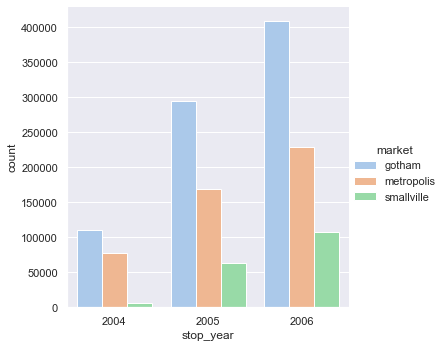

In [65]:
ym = sns.catplot("stop_year", data=subs_year.dropna(), kind="count", hue = "market")

Sprawdźmy jaki w danym roku i na danym rynku jest stosunek osób, które zrezygnowły do wszystkich subskrybentów

In [66]:
subs_gotham = subs[subs['market'] == 'gotham']
subs_metropolis = subs[subs['market'] == 'metropolis']
subs_smallville = subs[subs['market'] == 'smallville']

Rok 2006:

In [67]:
for i in [subs_gotham, subs_metropolis, subs_smallville]:
    x = round(len(i[i['stop_date'].dt.year == 2006])/(len(i[i['start_date'].dt.year <= 2006]) - len(i[i['stop_date'].dt.year < 2006]))*100,2)
    print('W 2006 roku w', i.iloc[0, 3], 'stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi', x)

W 2006 roku w gotham stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi 37.39
W 2006 roku w metropolis stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi 30.6
W 2006 roku w smallville stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi 21.53


Rok 2005:

In [68]:
for i in [subs_gotham, subs_metropolis, subs_smallville]:
    x = round(len(i[i['stop_date'].dt.year == 2005])/(len(i[i['start_date'].dt.year <= 2005]) - len(i[i['stop_date'].dt.year < 2005]))*100,2)
    print('W 2005 roku w', i.iloc[0, 3], 'stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi', x)

W 2005 roku w gotham stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi 27.21
W 2005 roku w metropolis stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi 24.35
W 2005 roku w smallville stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi 14.6


Rok 2004:

In [69]:
for i in [subs_gotham, subs_metropolis, subs_smallville]:
    x = round(len(i[i['stop_date'].dt.year == 2004])/len(i[i['start_date'].dt.year <= 2004])*100,2)
    print('W 2004 roku w', i.iloc[0, 3], 'stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi', x)

W 2004 roku w gotham stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi 20.77
W 2004 roku w metropolis stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi 18.99
W 2004 roku w smallville stosunek osób, które zrezygnowały do wszystkich subskrybentów na tym rynku wynosi 3.39


Wnioski: 
- Każdego roku najwięcej ludzi odchodziło z rynku Gotham, a najmniej z Smallville
- Największa liczba klientów odeszła w 2016 roku z rynku Gotham

#### Sprawdźmy jaki jest średni czas subskrypcji - tenure (aktywnych oraz nieaktywnych klientów)

In [70]:
subs_churned = subs[subs['churn'] == 1]
subs_retained = subs[subs['churn'] == 0]
print(round(subs['tenure'].mean(),2), ' - średni czas trwania subskrypcji bez podziału na klientów, którzy odeszli i pozostali')
print(round(subs_churned['tenure'].mean(),2), ' - średni czas trwania subskrypcji klientów, którzy zrezygnowali z sybskrypcji')
print(round(subs_retained['tenure'].mean(),2), ' - średni czas trwania subskrypcji klientów, którzy nie zrezygnowali z sybskrypcji')

408.76  - średni czas trwania subskrypcji bez podziału na klientów, którzy odeszli i pozostali
312.22  - średni czas trwania subskrypcji klientów, którzy zrezygnowali z sybskrypcji
497.5  - średni czas trwania subskrypcji klientów, którzy nie zrezygnowali z sybskrypcji


#### Pokażmy podstawowe statystyki dla monthly_fee oraz tenure

In [71]:
round(subs[['monthly_fee', 'tenure']].describe(),2) #bez podziału na klientów, którzy odeszli i pozostali

,monthly_fee,tenure
count,3061718.00,3061718.00
mean,38.99,408.76
std,16.65,273.16
min,7.00,0.00
25%,30.00,176.00
50%,40.00,380.00
75%,40.00,596.00
max,360.00,1092.00


In [72]:
round(subs[subs['churn'] == 1][['monthly_fee', 'tenure']].describe(),2) #klienci, którzy odeszli

,monthly_fee,tenure
count,1466419.00,1466419.00
mean,40.14,312.22
std,18.23,230.22
min,7.00,0.00
25%,30.00,120.00
50%,40.00,345.00
75%,40.00,436.00
max,360.00,1090.00


In [73]:
round(subs[subs['churn'] == 0][['monthly_fee', 'tenure']].describe(),2) #klienci, którzy pozostali

,monthly_fee,tenure
count,1595299.00,1595299.00
mean,37.94,497.50
std,14.98,279.37
min,10.00,0.00
25%,30.00,287.00
50%,35.00,484.00
75%,40.00,717.00
max,300.00,1092.00


#### Sprawdź my jak wyglądają histogramy monthly_fee oraz tenure

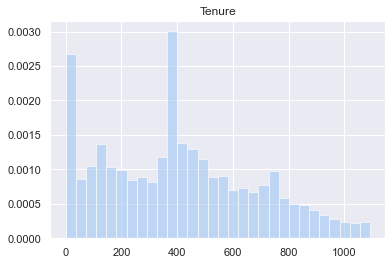

In [74]:
subs['tenure'].hist(bins = 30, alpha = 0.6, density = True)
plt.title('Tenure')
plt.show() 

Zbadanie skośności rozkładu 'tenure'

In [75]:
subs['tenure'].skew()

0.3806215254891536

Wnioski: Rozkład prawostronnie skośny.

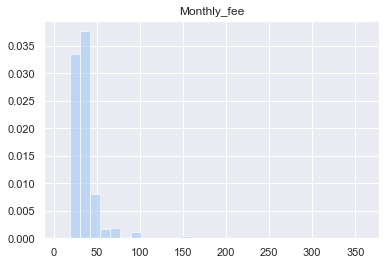

In [76]:
subs['monthly_fee'].hist(bins = 30, alpha = 0.6, density = True)
plt.title('Monthly_fee')
plt.show()

Zbadanie skośności rozkładu 'monthly_fee'

In [77]:
subs['monthly_fee'].skew() 

4.903755115329136

Wnioski: Rozkład prawostronnie skośny.

Histogram monthly_fee oraz tenure z podziałem na klientów, którzy pozostali oraz tych którzy odeszli.

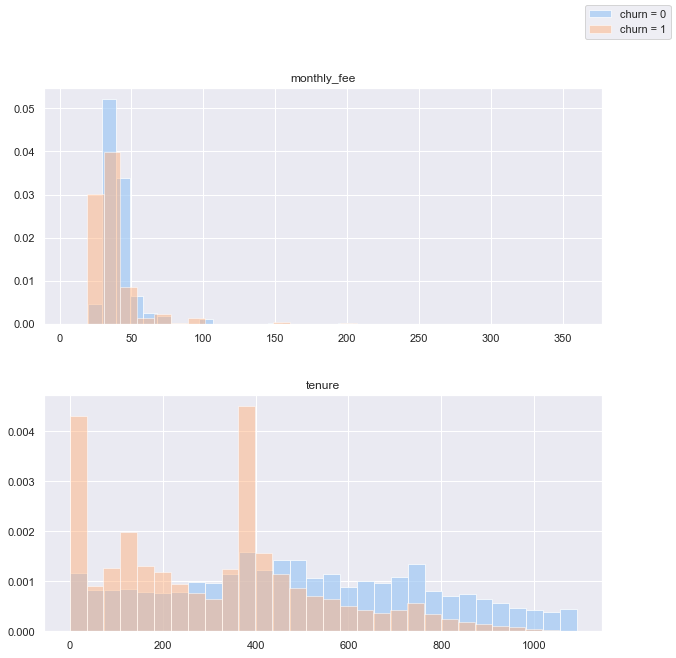

In [78]:
fig, ax = plt.subplots(2,1, figsize = (10,10))
subs[subs.churn == 0][['tenure','monthly_fee']].hist(bins = 30, alpha = 0.7, ax = ax, density = True) #niebieski - klienci którzy pozostali
subs[subs.churn == 1][['tenure','monthly_fee']].hist(bins = 30, alpha = 0.5, ax = ax, density = True) #czerwony - klienci, którzy odeszli
fig.legend(['churn = 0','churn = 1'], loc = 'upper right')
plt.show()

W odniesieniu to histogramu monthly_fee (churn = 1) możemy zobaczyć szczyt w okolicy 30-40. Zdecydowana większość klientów decydowała się na taką wysokość miesięcznych opłat za usługę. 

Na histogramie tenure (churn = 1) widzimy, trzy szczyty.
Pierwszy na samym początku subskrypcji, drugi w okolicy 120 dnia subskrypcji (cztery miesiące), a trzeci około roku. Przyjrzyjmy się tym dabym trochę bliżej. Sprawdźmy jak wygląda rozkład tenure z podziałem na stop_type.

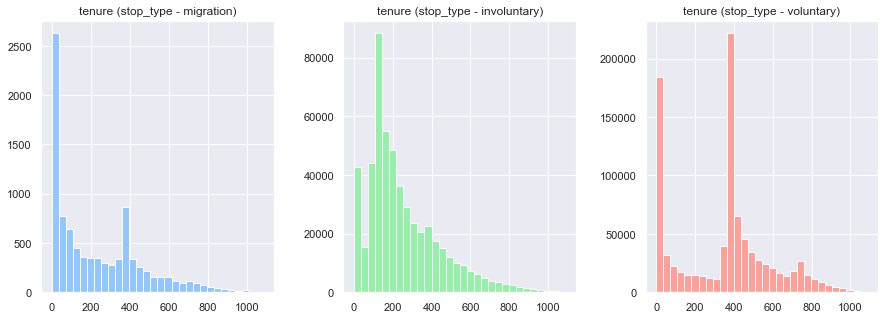

In [79]:
gs = gridspec.GridSpec(1, 3)

plt.figure(figsize = (15,5))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
subs[subs['stop_type'] == 'm'][['tenure']].hist(bins = 30, ax = ax,  color = '#92C6FF')
plt.title('tenure (stop_type - migration)')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
subs[subs['stop_type'] == 'i'][['tenure']].hist(bins = 30, ax = ax, color = '#97F0AA')
plt.title('tenure (stop_type - involuntary)')

ax = plt.subplot(gs[0, 2]) # row 0, col 2
subs[subs['stop_type'] == 'v'][['tenure']].hist(bins = 30, ax = ax, color = '#FF9F9A')
plt.title('tenure (stop_type - voluntary)')
plt.show()

Sprawdźmy jeszcze jak wyglądają wartości tenure z podziałem na stop_type - wyświetlimy 25 wartości malejąco. 

In [80]:
subs.groupby(['tenure','stop_type'])['customer_id'].size().sort_values(ascending = False).head(25)

tenure  stop_type
365     v            38632
366     v            26104
367     v            15098
1       v            14979
2       v            11130
368     v            10350
364     v            10255
3       v             8922
7       v             8135
369     v             7954
10      v             7637
8       v             7471
9       v             7464
4       v             7404
6       v             7249
14      v             7246
11      v             7240
5       v             6985
370     v             6950
13      v             6873
12      v             6707
371     v             6416
123     i             6321
124     i             5807
122     i             5539
Name: customer_id, dtype: int64

Wnioski:

W przypadku migracji widzimy dwa wyraźne szczyty. Jeden na początku subskrypcji, a drugi w okolicy roku. Pierwszy szczyt - zaprzestanie subskrypcji na samym jej początku mogło wiązać się z tym, iż karta klienta mogła zostać odrzucona, dane były niepoprawne lub klient szybko się rozmyślił. Drugi szczyt w okolicy roku może sugerować, że klientowi kończyła się subskrypcja i nie chciał jej przedłużyć (znalazł inną lepszą ofertę).

W przypadku subskrypcji przerwanej przez opratora (involuntary) również widzimy wyraźne dwa szczyty. Jeden na samym początku, a drugi w 120 dniu subskrypcji. Pierwszy szczyt może występować z tych samych powodów co w migracji, drugi natomiast może sugerować, że operator ustalił granicę nie płacenia rachunków po przekroczeniu, której klienci sa usuwani z listy subskrybentów i w tym przypadku jest to około 4 miesięcy. 

W przypadku subskrypcji przerwanej przez klienta (voluntary) sytuacja wygląda podobnie jak w przypadku migracji mamy dwa szczyty, jeden na początku subskrypcji, a drugi w okolicy roku. Ilość rezygnacji w okolicy roku jest bardzo duża co może świadczyć o tym, że klient nie przedłużył rocznej subskrypcji.

#### Sprawdzenie obserwacji odstających

Obserwacja odstająca jest obserwacją, która przyjmuje wartość:
- Większą niż półtora odstępu międzykwartylowego (Q3 – Q1), od trzeciego kwartyla (Q3).
- Mniejszą niż półtora odstępu międzykwartylowego (Q3 – Q1), od pierwszego kwartyla (Q1).

In [81]:
subs_num = subs.copy()
subs_num = subs_num[['monthly_fee', 'tenure']]

q1 = subs_num.quantile(0.25) 
q3 = subs_num.quantile(0.75)
iqr = q3-q1

low_boundary = (q1 - 1.5 * iqr)
upp_boundary = (q3 + 1.5 * iqr)
num_of_out_L = (subs_num[iqr.index] < low_boundary).sum()
num_of_out_U = (subs_num[iqr.index] > upp_boundary).sum()

outliers = pd.DataFrame({'lower_value':low_boundary, 'upper_boundary':upp_boundary,'num_of_outliers_L':num_of_out_L, 'num_of_outliers_U':num_of_out_U})
print(outliers)

             lower_value  upper_boundary  num_of_outliers_L  num_of_outliers_U
monthly_fee         15.0            55.0               1303             207337
tenure            -454.0          1226.0                  0                  0


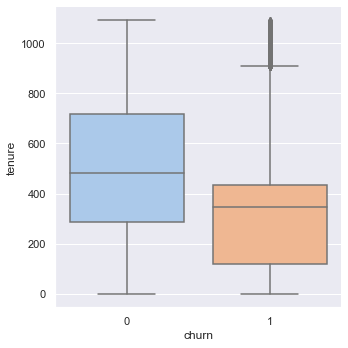

In [82]:
sns.catplot("churn", "tenure", data=subs, kind="box")
plt.show()

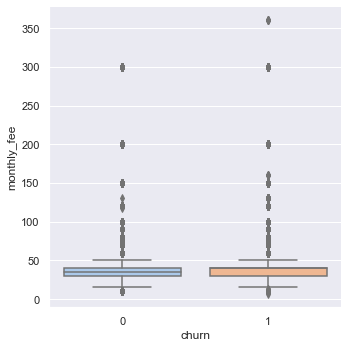

In [83]:
sns.catplot("churn", "monthly_fee", data=subs, kind="box")
plt.show()

In [84]:
subs.groupby('monthly_fee').size()

monthly_fee
7            1
10        1299
12           1
13           2
15          38
16           1
18           2
19           3
20      137233
22           9
25        2923
27           7
30     1065940
35      309385
37           1
40     1048212
45       57936
50      231388
60       62846
70       36185
75       33985
80        8734
90          79
100      41071
117          1
120       3463
130         26
150      13582
160          4
200       6897
300        458
360          6
dtype: int64

Wnioski: Widzimy, ze istnieją obserwacje odstające, jednakże w naszym przypadku nie będziemy ich usuwać, gdyż nie stwierdzono, że są to błędy w danych.

#### Jaki jest średni czas subskrypcji w zależności od rynku oraz kanału

In [85]:
mean_tenure_market_channel = pd.pivot_table(subs, index = ['market', 'channel'], values = ['tenure'], aggfunc = 'mean', margins = False)
round(mean_tenure_market_channel, 2)

tenure
market     channel        
gotham     chain    346.75
           dealer   389.88
           mail     342.94
           store    431.10
metropolis chain    408.53
           dealer   419.48
           mail     357.42
           store    461.54
smallville chain    452.71
           dealer   476.37
           mail     438.12
           store    467.35

Wnioski:
- W Gotham najdłużej pozostawali klienci z kanału dystrybucji Chain, natomiast najkrócej ze Store
- W Metropolis najdłużej pozostawali klienci z kanału dystrybucji Store, natomiast najkrócej z Mail
- W Smallville najdłużej pozostawali klienci z kanału dystrybucji Chain, natomiast najkrócej ze Store

#### Sprawdźmy czy istnieje związek między monthly_fee oraz tenure

Sprawdźmy jaki ma rozkład zmienna monthly_fee oraz tenure

Testowanie hipotezy<br>
H0: Zmienna ma rozkład normalny<br>
H1: Zmienna nie ma rozkładu normalnego<br>

Stopień istotności przyjmujemy jako 0.05

In [86]:
# test na normalność rozkładu tenure
stat_t, p_t = scipy.stats.normaltest(subs['tenure'])
print('stat_t=%.3f, pvalue=%.3f' % (stat_t, p_t))
if p_t < 0.05:
    print('Odrzucamy hipotezę H0, zatem prawdopodobnie zmienna tenure nie ma rozkładu normalnego')
else:
    print('Przyjmujemy hipotezę H0, zatem prawdopodobnie zmienna tenure ma rozkład normalny')

stat_t=194902.060, pvalue=0.000
Odrzucamy hipotezę H0, zatem prawdopodobnie zmienna tenure nie ma rozkładu normalnego


In [87]:
# test na normalność rozkładu monthly_fee
stat_m, p_m = scipy.stats.normaltest(subs['monthly_fee'])
print('stat_m=%.3f, pvalue=%.3f' % (stat_m, p_m))
if p_m< 0.05:
    print('Odrzucamy hipotezę H0, zatem prawdopodobnie zmienna monthly_fee nie ma rozkładu normalnego')
else:
    print('Przyjmujemy hipotezę H0, zatem prawdopodobnie zmienna monthly_fee ma rozkład normalny')

stat_m=3051362.524, pvalue=0.000
Odrzucamy hipotezę H0, zatem prawdopodobnie zmienna monthly_fee nie ma rozkładu normalnego


#### Sprawdzamy koralację między zmiennymi monthly_fee oraz tenure

W związku z faktem, iż zmienne nie mają rozkładu normalnego, sprawdzamy korelacje za pomocą współczynnika korelacji rang Spearmana.

Testowanie hipotezy<br>
H0: Zmienne są niezależne<br>
H1: Zmienne są zależne<br>

Wzór na korelację rho-Spearmana 

$rho(x,y) = {\frac{cov(R_x, R_y)}{\sigma_{R_x}*\sigma_{R_y}}}$

$cov(R_x,R_y) = E(R_x*R_y) - (E(R_x)*E(R_y))$

gdzie:

$rho(x,y)$ - współczynnik korelacji rho-Spearmana pomiędzy zmiennymi x i y<br>
$R_x$ - porangowane wartości zmiennej X<br>
$R_y$ - porangowane wartości zmiennej Y<br>
$cov(R_x,R_y)$ - kowariancja pomiędzy zmiennymi $R_x$ i $R_y$<br>
$\sigma$ - odchylenie standardowe z populacji<br>
$E$ - wartość oczekiwana

Stopień istotności przyjmujemy jako 0.05

In [88]:
# sprawdzenie korelacji pomiędzy zmiennymi numerycznymi (współczynnik korelacji rang Spearmana)
rho, p_val = scipy.stats.spearmanr(subs['tenure'], subs['monthly_fee'])
print('rho=%.3f, p_val=%.3f' % (rho, p_val))
if p_val < 0.05:
    print('Odrzucamy hipotezę H0, zatem prawdopodobnie zmienne są zależne')
else:
    print('Przyjmujemy hipotezę H0, zatem prawdopodobnie zmienne są niezależne')

rho=-0.080, p_val=0.000
Odrzucamy hipotezę H0, zatem prawdopodobnie zmienne są zależne


In [89]:
subs_corr = subs[['monthly_fee','tenure']]

In [90]:
subs_corr.corr(method='spearman')

,monthly_fee,tenure
monthly_fee,1.000000,-0.080159
tenure,-0.080159,1.000000


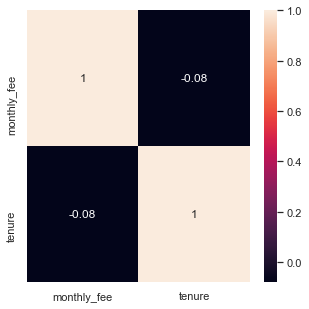

In [91]:
plt.figure(figsize=(5,5))
sns.heatmap(subs_corr.corr(method='spearman'), annot=True)
plt.show()

Widzimy, iż korelacja między tenure oraz monthly_fee jest ujemna i przyjmuje wartości bliskie 0. Ujemna korelacja oznacza, że wraz ze wzrostem/spadkiem jednej zmiennej, druga zmienna zachowuje się odwrotnie i odpowiednio spada bądź rośnie.

Współczynnik rho wynosi -0,08 i oznacza to słabą korelacje.

### 3. Podusmowanie

Po przeanalizowaniu danych dotyczących subskrypcji sieci komórkowej możemy wysunąć kilka interesujących wniosków.<br> 
W 2006 roku nastąpił znaczny spadek w ilości nowych klientów w porównaniu do poprzedniego roku. Trzeba by było bliżej przyjrzeć się tematowi, sprawdzić co mogło być przyczyną takiego spadku zainteresowania wśród nowych klientów, zastanowić się co można by było zrobić, aby zachęcić klientów do przyłączenia się do sieci. <br> 
Widzimy, iż na rynek Gotham przynosi najwięcej klientów, jednakże liczba klientów, którzy zrezygnowali z subskrypcji na tym rynku przewyższa liczbę klientów którzy zostali. Należałoby sprawdzić co można zrobić, aby zapobiec odpływowi klientów na tym rynku. Może rozwiązaniem mogły by być dodatkowe benefity.<br> 
Najwięcej klientów decyduje się na bottom plan i to on przynosi największe zyski. Tutaj również liczba klientów, którzy pozostali jest większa od liczby klientów którzy odeszli. Najmniej klientów decyduje się na top plan i w tym przypadku liczba klientów odchodzących przewyższa liczbę klientów, którzy pozostają. Warto byłoby spróbować uatrakcyjnić top plan i bardziej zadbać o klientów, którzy decydują się zapłacić dużo więcej za usługę miesięcznie. <br> 
W przypadku kanałów dystrybucji największą uwagę przykuwa fakt, iż najwięcej klientów zostaje z kanału store. Należałoby sprawdzić co może być tego przyczyną i dlaczego inne kanały radzą sobie gorzej.<br> 
Najczęstszą przyczyną zakończenia subskrypcji była rezygnacja klienta. Szczególnie istotne jest to, kiedy największa ilość klientów odchodziła. Analizując histogram tenure widzimy, iż było to w okolicy roku od rozpoczęcia subskrypcji. Aby zapobiec odpływowi klientów w tym czasie należałoby rozważyć zaproponowanie mu dodatkowych benefitów przed upływem tego czasu, a może symboliczne zmniejszenie miesięcznej opłaty za usługę. <br> 
W powyższej analizie zwróciliśmy również uwagę na fakt, iż między monthly_fee oraz tenure występuje słaba korelacja.<br> 




